In [1]:
import pandas
import requests
import scipy
import os
import sys
import numpy
from pathlib import Path
import requests
from matplotlib import pyplot, cm 

In [2]:
HTSW = os.path.expanduser('~diane/proj/htsworkflow')
if HTSW not in sys.path:
    sys.path.append(HTSW)
from htsworkflow.submission.encoded import ENCODED

In [3]:
LRS = str(Path('~/proj/long-rna-seq-condor').expanduser())
if LRS not in sys.path:
    sys.path.append(LRS)
from woldrnaseq import models, madqc

In [4]:
server = ENCODED('www.encodeproject.org')
server.load_netrc()

In [5]:
def lookup_experiment(experiment_id):
    experiment = server.get_json(experiment_id)
    for replicate in experiment['replicates']:
        library = replicate['library']
        if 'aliases' not in library:
            library = server.get_json(replicate['library'])

        print(experiment['accession'], library['accession'], library['aliases'], experiment['description'])

In [6]:
def files_to_library(experiment, file_object):
    libraries = None
    library_aliases = None
    assert len(file_object['replicate_libraries']) == 1
    for file_library_id in file_object['replicate_libraries']:
        for experiment_replicate in experiment['replicates']:
            library = experiment_replicate['library']
            if library['@id'] == file_library_id:
                libraries = library['accession']
                library_aliases = library['aliases'][0]
    return (libraries, library_aliases)

def find_experiment_quality_metrics(experiment):   
    qc_report = {
        'SamtoolsFlagstatsQualityMetric': parse_samtools_stats,
        'StarQualityMetric': parse_star_stats,
        'GeneTypeQuantificationQualityMetric': parse_gene_type_quantification,
        'MadQualityMetric': parse_mad_metric,
        'GeneQuantificationQualityMetric': parse_genes_detected,
    }

    library_map = {}
    library_aliases_map = {}
    for f in experiment['files']:
        libraries, aliases = files_to_library(experiment, f)
        library_map[f['@id']] = libraries
        library_aliases_map[f['@id']] = aliases
        
    reports = {}
    for f in experiment['files']:
        if 'quality_metrics' in f:
            for metric in f['quality_metrics']:
                metric_type = metric['@type'][0]
                value = qc_report[metric_type](metric)
                for_libraries = tuple([library_aliases_map[x] for x in value['quality_metric_of']])
                reports.setdefault(metric_type, {})[for_libraries] = value
    return reports

def format_alias(alias):
    return ",".join([x.split(':')[1] for x in alias])

def report_experiment(experiment):
    print(experiment['accession'], experiment['description'])
    reports = find_experiment_quality_metrics(experiment)
    
    star_quality = {}
    for library_alias in reports['StarQualityMetric']:
        formatted_alias = format_alias(library_alias)
        star_qc = reports['StarQualityMetric'][library_alias]
        mapped = star_qc['Number of reads mapped to multiple loci'] + star_qc['Uniquely mapped reads number']
        fraction_mapped = mapped / star_qc['Number of input reads']
        star_quality[formatted_alias] = {
            'multi': star_qc['Number of reads mapped to multiple loci'],
            'uniq': star_qc['Uniquely mapped reads number'],
            'mapped': mapped,
            'total': star_qc['Number of input reads'],
            '%mapped': "{:.4}".format(fraction_mapped * 100),
        }
    print(pandas.DataFrame(star_quality).T)
            

    if 'MadQualityMetric' in reports:
        mad = reports['MadQualityMetric']
        for library_alias in mad:
            formatted_alias = format_alias(library_alias)
            print(formatted_alias, 'Spearman', mad[library_alias]['Spearman correlation'])    
    else:
        print('No correlation for {}'.format(library_alias))

    gene_type = {}
    for library_alias in reports['GeneTypeQuantificationQualityMetric']:
        formatted_alias = format_alias(library_alias)
        gene_type_counts = reports['GeneTypeQuantificationQualityMetric'][library_alias]
        del gene_type_counts['@id']
        del gene_type_counts['quality_metric_of']
        gene_type[formatted_alias] = gene_type_counts
        
    gene_type = pandas.DataFrame(gene_type)
    f = pyplot.figure(figsize=(8,8))
    ax = f.add_subplot(1,1,1)
    gene_type.T.plot.bar(stacked=True, ax=ax)
    #return gene_type   
    #reports['GeneQuantificationQualityMetric']

In [7]:
def load_kallisto_transcript_abunduance(filename):
    def identity(x):
        return x
    def convert_transcript_id(x):
        if x.startswith('ERCC'):
            return 'tSpikein_' + x
        elif x == 'phiX174':
            return 'tSpikein_phiX174'
        else:
            return x
    records = []
    header = ['transcript_id', 'gene_id', 'transcript_name', 'transcript_type']
    target_fields = [0, 1, 4, 7]
    target_converters = [convert_transcript_id, identity, identity, identity]
    field_converters = [identity, int, float, float, float]
    response = requests.get(filename)
    instream = response.iter_lines()
    abundance_header = next(instream).decode('ascii')
    abundance_header = abundance_header.strip().split('\t')
    header.extend(abundance_header[1:])
    for line in instream:
        fields = line.decode('ascii').rstrip().split('\t')
        targets = fields[0].split('|')
        row = []
        for i, converter in zip(target_fields, target_converters):
            if len(targets) > i:
                row.append(converter(targets[i]))
            else:
                row.append(None)
        for i, converter in enumerate(field_converters[1:]):
            row.append(converter(fields[i+1]))
        records.append(row)
    df = pandas.DataFrame(records, columns=header)
    return df.set_index('transcript_id')

def load_kallisto_quantifications(experiment_files, index=None, column='tpm'):
    quantifications = []
    filenames = []
    for filename in experiment_files:
        table = load_kallisto_transcript_abunduance(filename)
        table = table[[column]]

        quantifications.append(table[column])
        _, name = os.path.split(filename)
        filenames.append(name)

    df = pandas.concat(quantifications, axis=1)
    if index:
        df.columns = index
    else:
        df.columns = filenames
    return df

def load_kallisto_replicates(experiment, libraries, column):
    analysis_files = []
    library_ids = []

    assert isinstance(experiment, pandas.Series)
    for library_id in experiment.replicates:
        library_ids.append(library_id)
        library = libraries.loc[library_id]
        analysis_dir = Path(library.analysis_dir).expanduser()
        abundance = analysis_dir / 'abundance.tsv'
        if not abundance.exists():
            raise RuntimeError("{} doesn't exist".format(result[0]))
        else:
            analysis_files.append(abundance)
    quantifications = load_kallisto_quantifications(
        analysis_files, index=library_ids, column=column
    )
    print('quantifications', experiment.name, quantifications.shape)
    return quantifications



In [8]:
query = "https://www.encodeproject.org/search/?type=Experiment&lab.title=Barbara+Wold%2C+Caltech&award.rfa=ENCODE4&assay_title=total+RNA-seq"

In [9]:
#query = "https://www.encodeproject.org/search/?type=Experiment&@id=%2Fexperiments%2FENCSR379DEC%2F&@id=%2Fexperiments%2FENCSR877FRY%2F&@id=%2Fexperiments%2FENCSR631FXT%2F&@id=%2Fexperiments%2FENCSR306IAW%2F&@id=%2Fexperiments%2FENCSR336VTK%2F&@id=%2Fexperiments%2FENCSR429EGC%2F"
#query = "https://www.encodeproject.org/search/?type=Experiment&@id=%2Fexperiments%2FENCSR479MNN%2F&@id=%2Fexperiments%2FENCSR288RRZ%2F&@id=%2Fexperiments%2FENCSR899OKE%2F&@id=%2Fexperiments%2FENCSR464VSR%2F&@id=%2Fexperiments%2FENCSR774MGO%2F&@id=%2Fexperiments%2FENCSR129VBC%2F&@id=%2Fexperiments%2FENCSR420YFF%2F&@id=%2Fexperiments%2FENCSR942YMN%2F&@id=%2Fexperiments%2FENCSR648YUM%2F&@id=%2Fexperiments%2FENCSR903XMI%2F&@id=%2Fexperiments%2FENCSR244HHV%2F&@id=%2Fexperiments%2FENCSR168PXI%2F&@id=%2Fexperiments%2FENCSR308XAR%2F&@id=%2Fexperiments%2FENCSR484WZL%2F"

search = server.get_json(query)
experiments = []
for row in search['@graph']:
    experiment = server.get_json(row['@id'])
    experiments.append(experiment)
    #report_experiment(experiment)

In [10]:
len(experiments)

147

In [17]:
def kallisto_rsem_scatter(kallisto, rsem, experiment, library, threshold=0.8, ax=None):
    #fontname = 'Arial'
    fontname = 'DejaVu Sans'
    fontsize = 14
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)

    left = kallisto.to_frame()
    right = rsem.to_frame()
    counts = left.merge(right, left_index=True, right_index=True, how='inner')
    left_name = 'kallisto'
    right_name = 'RSEM'
    counts.columns = [left_name, right_name]
    
    rel_diff = numpy.abs(counts[left_name]-counts[right_name])/(counts.max(axis=1)+1)
    
    set1 = cm.get_cmap('Set1').colors
    #colors = [{True: set1[0], False: set1[1]}[x] for x in (rel_diff > threshold).values]
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in counts.index]
    
    #counts.plot.scatter(x=cell_id+"_x", y=cell_id+"_y", ax=ax, s=2)
    ax.scatter(counts[left_name], counts[right_name], c=colors, s=2)
    b = 6
    lim = numpy.arange(0.1, counts.max().max(), 0.1)
    lim_up = lim + b
    lim_down = lim -b
    ax.plot(lim, lim, c=set1[2])

    cell_id = experiment['accession'] + '/' + library['accession']
    fragment_length = library.get('average_fragment_size', 'N/A')
    fragment_length_cv = library.get('fragment_length_CV', 'N/A')
    spearman = scipy.stats.spearmanr(counts[left_name][-97:], counts[right_name][-97:])[0]
    gene_count = counts[counts > 0].count().max()
    ax.set_title(f'Experiment ID: {cell_id}\nTranscripts: {gene_count}\nInsert: {fragment_length}bp {fragment_length_cv}%\nSpike Spear: {spearman}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(left_name, fontsize=fontsize, fontfamily=fontname)
    ax.set_ylabel(right_name, fontsize=fontsize, fontfamily=fontname)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)


In [12]:
def is_kallisto(f):
    return '/files/ENCFF471EAM/' in f['derived_from']

In [18]:
def load_transcripts_by_library(experiment):
    quants = {}
    genome = experiment['assembly']
    if len(genome) > 0 and genome[0] == 'GRCh38':
        for f in e['files']:
            genome_annotation = f.get('genome_annotation', [])
            if genome_annotation == 'V29' and f['output_type'] == 'transcript quantifications':
                #print(e['@id'], f['@id'], is_kallisto(f), f['href'])
                url = 'https://www.encodeproject.org' + f['href']
                library_id = f['replicate_libraries'][0]
                if is_kallisto(f):
                    quants.setdefault(library_id, {})["kallisto"] = load_kallisto_transcript_abunduance(url)
                else:
                    quants.setdefault(library_id, {})["rsem"] = madqc.load_rsem_quantifications([url], ['TPM'], column='TPM')
    return quants

In [16]:
rsem.columns

Index(['TPM'], dtype='object')

# All Wold total RNA experiments with a fragment length CV defined.

<ipython-input-17-b2f471b86416>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = pyplot.figure()


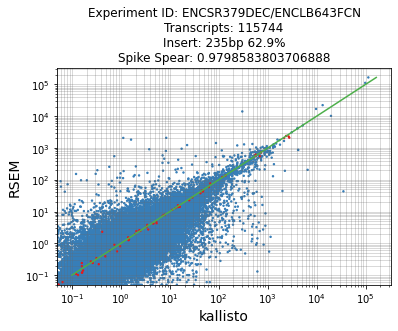

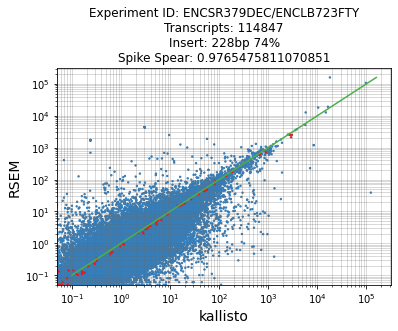

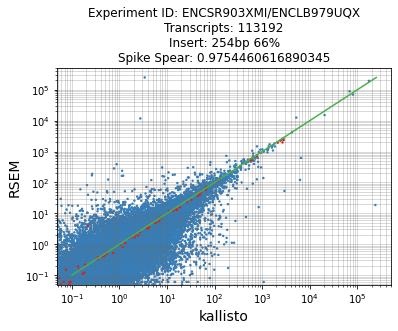

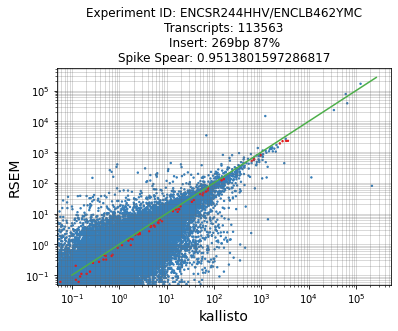

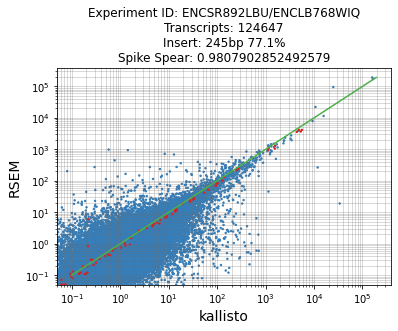

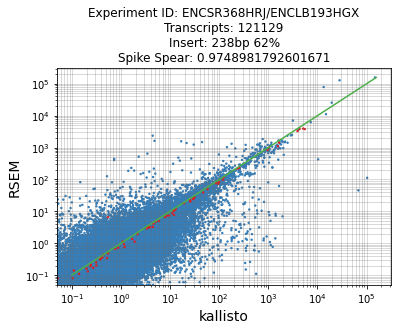

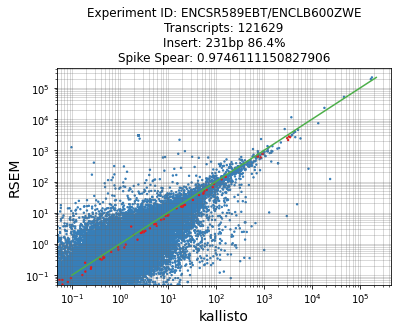

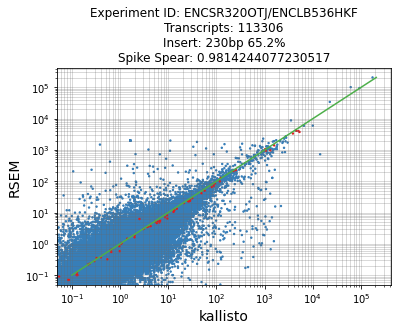

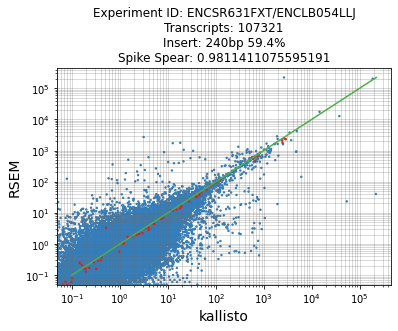

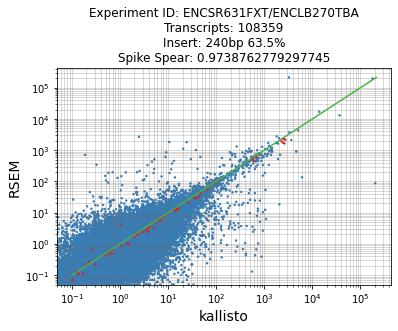

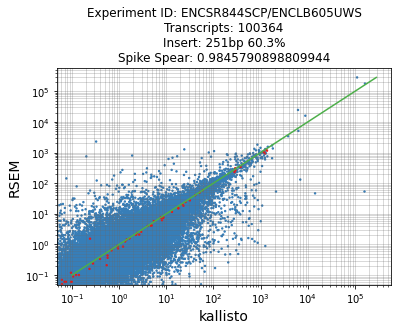

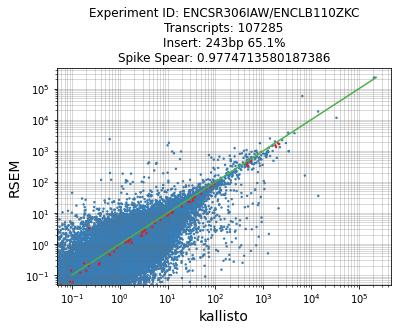

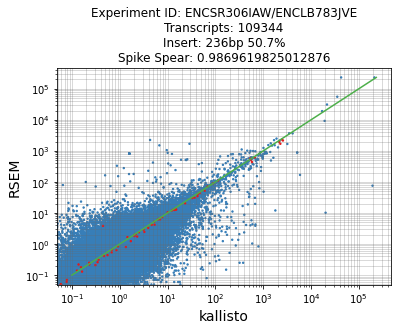

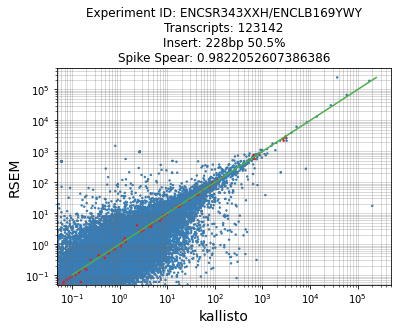

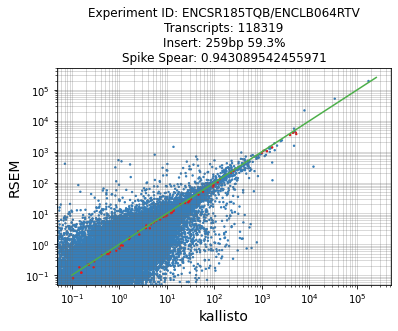

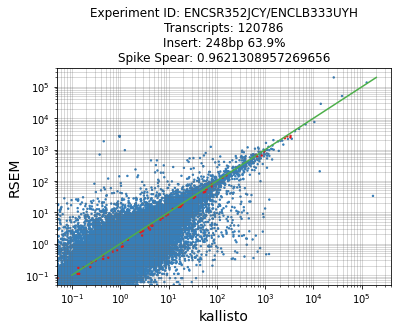

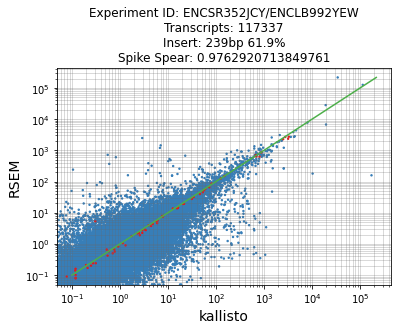

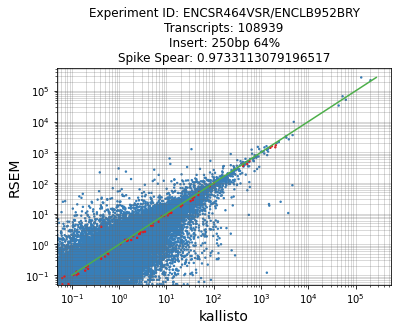

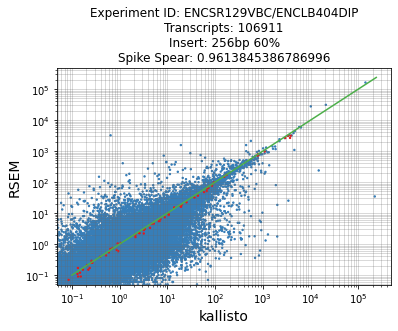

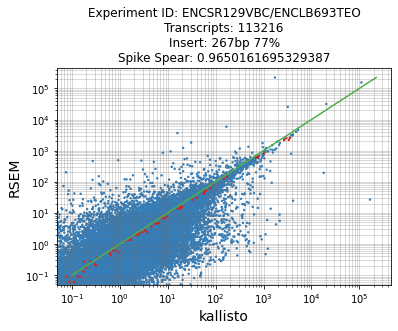

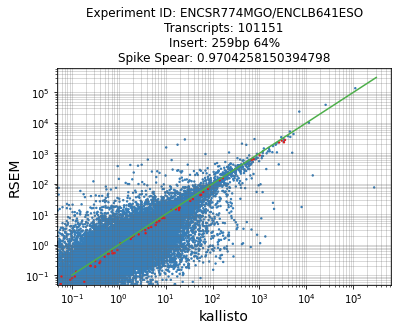

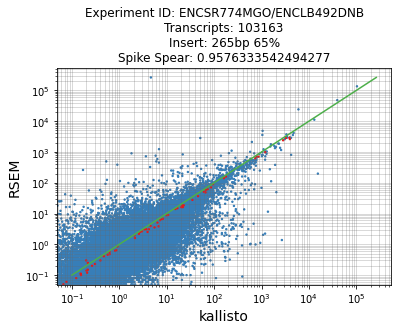

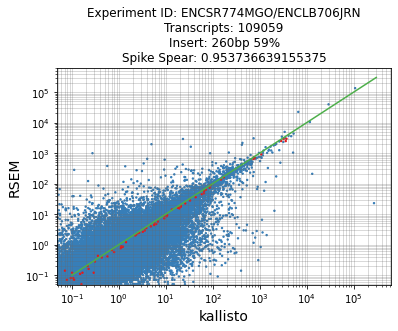

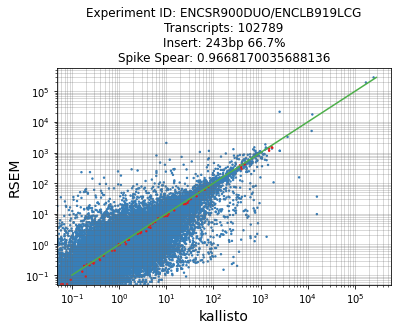

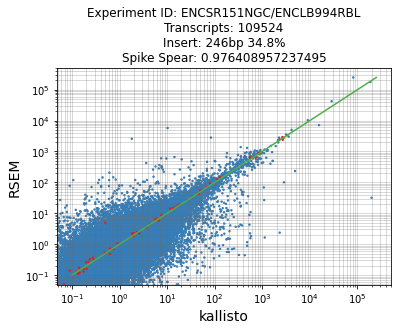

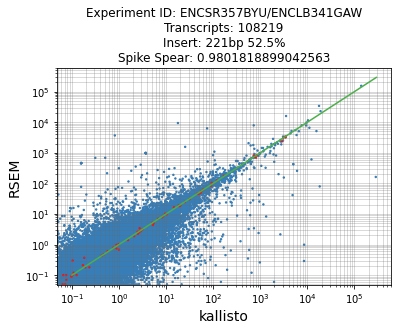

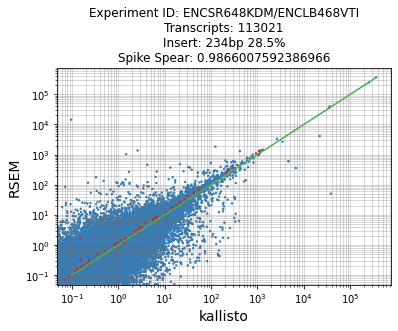

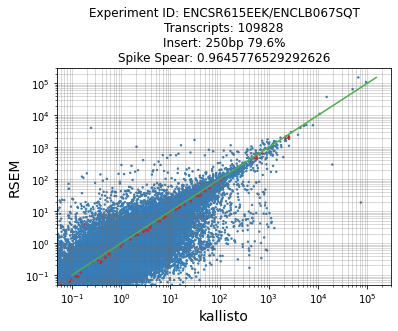

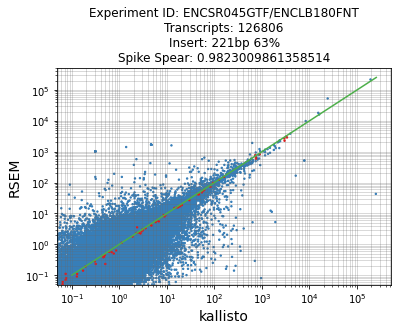

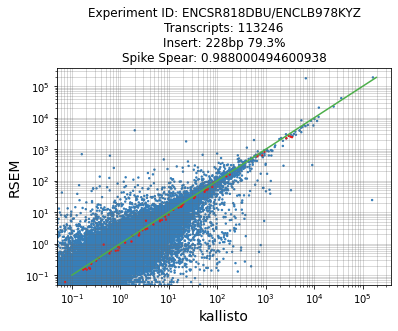

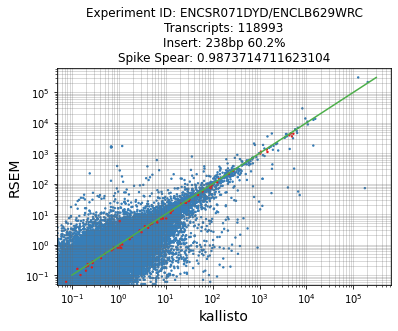

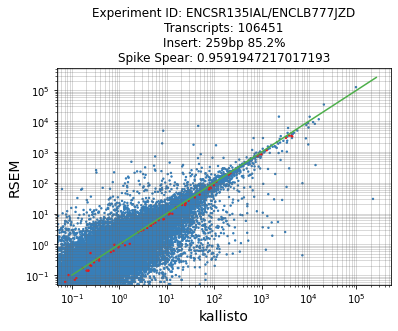

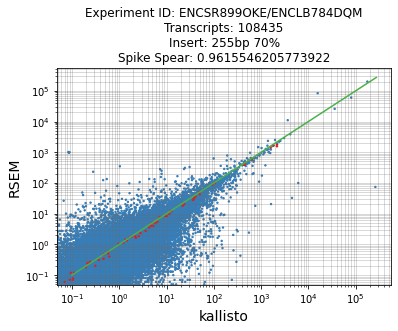

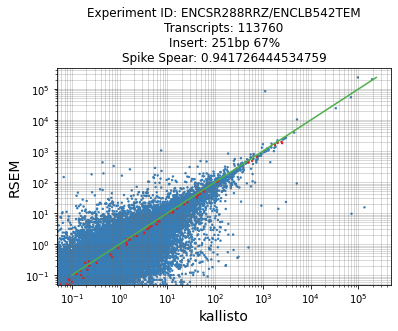

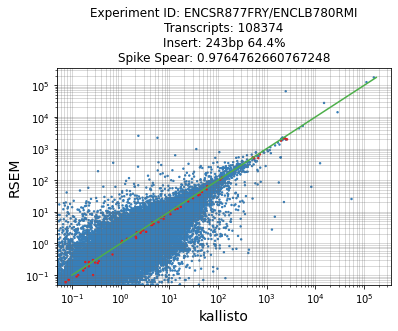

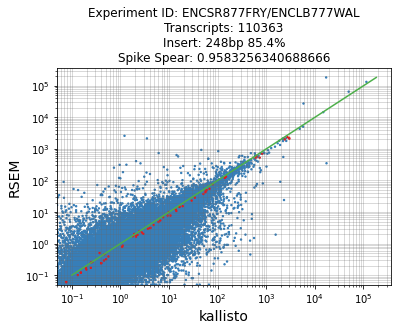

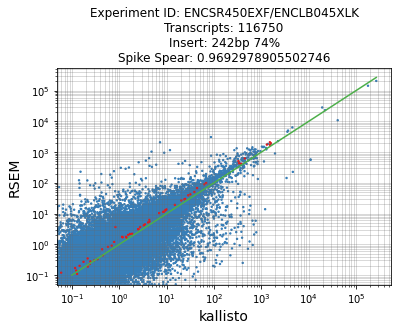

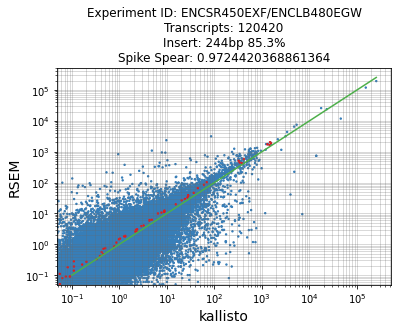

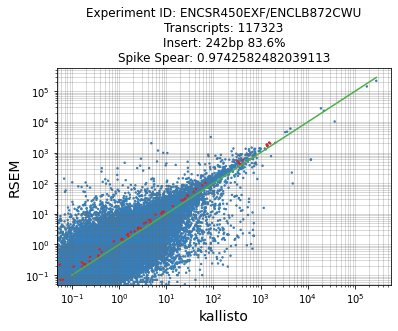

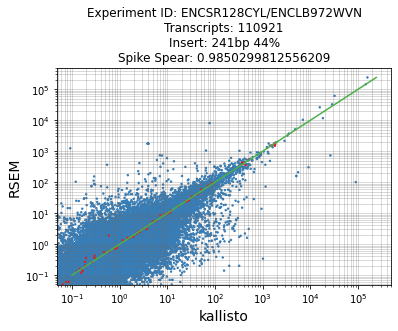

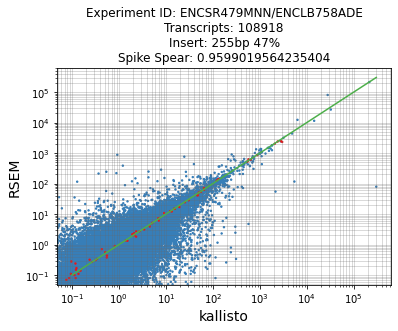

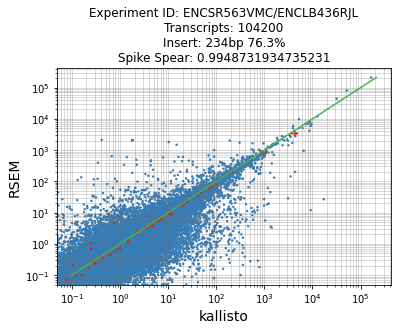

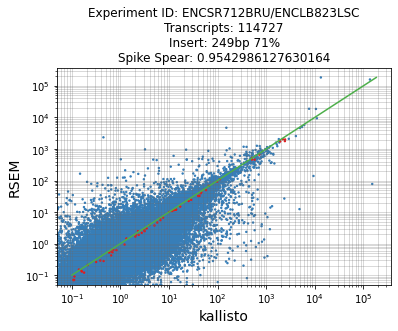

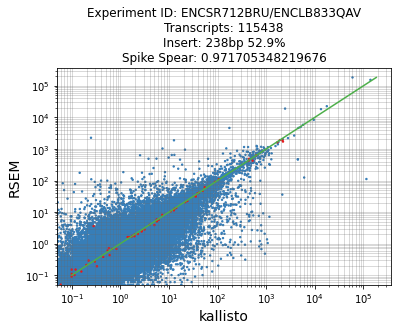

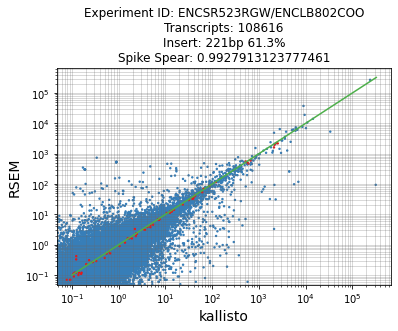

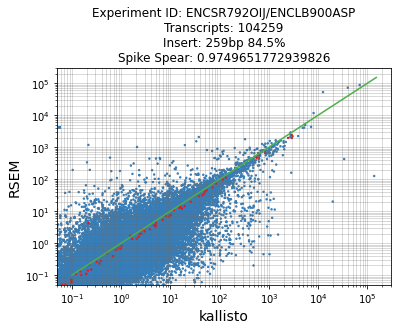

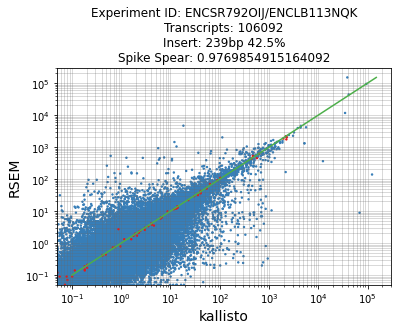

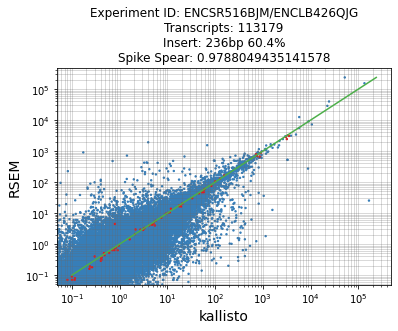

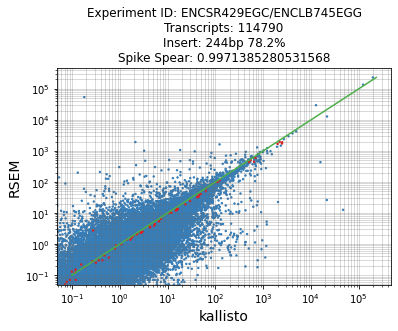

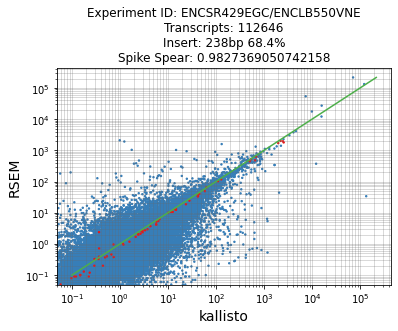

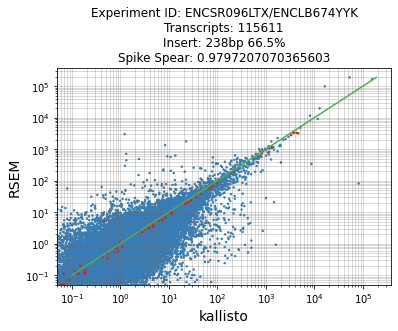

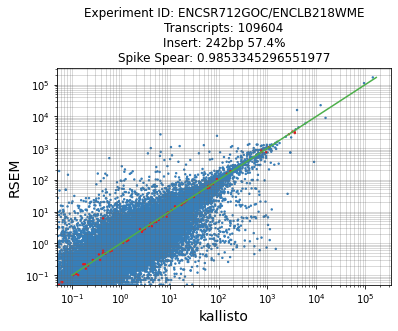

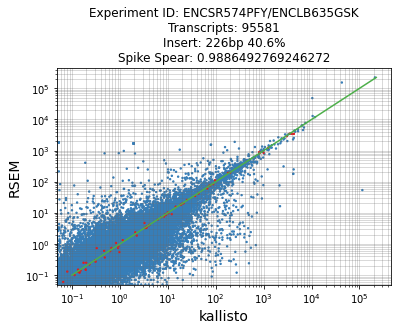

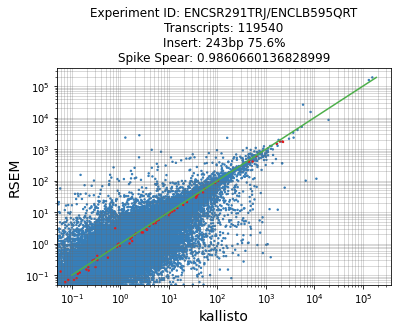

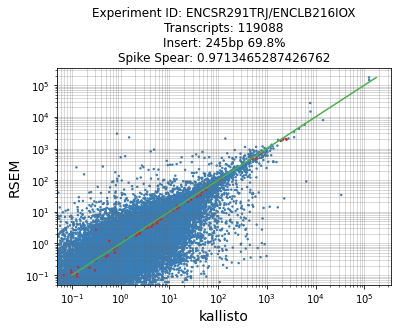

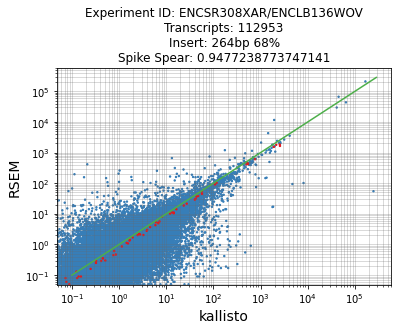

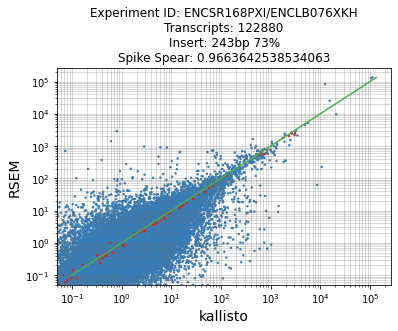

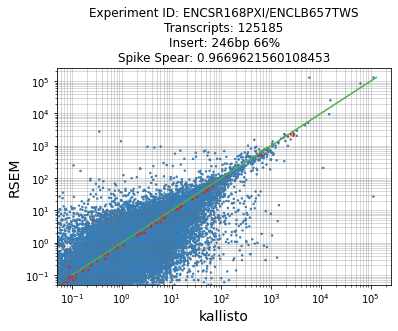

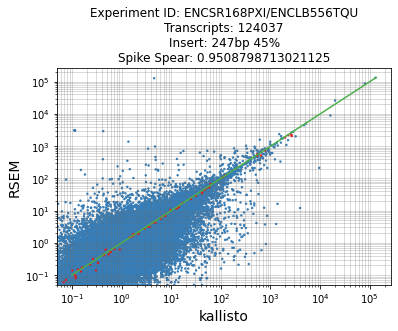

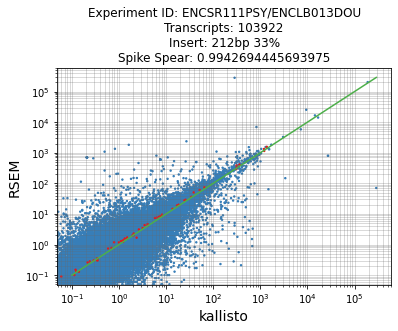

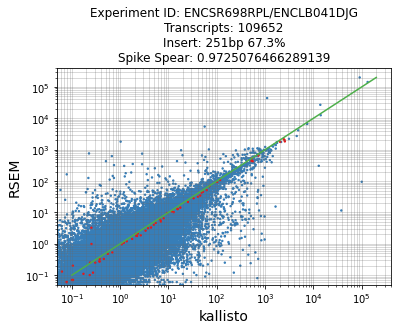

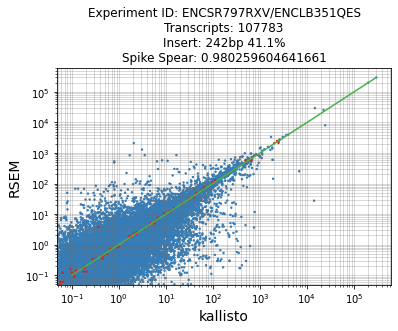

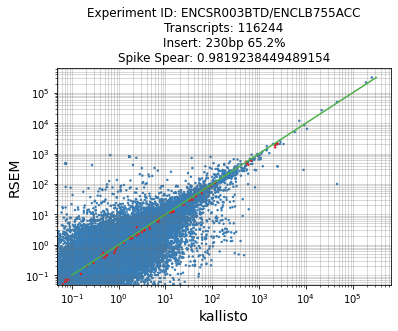

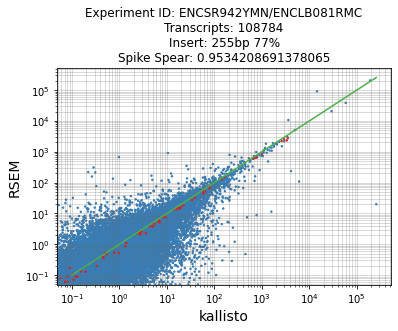

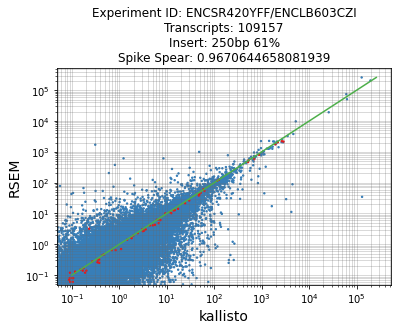

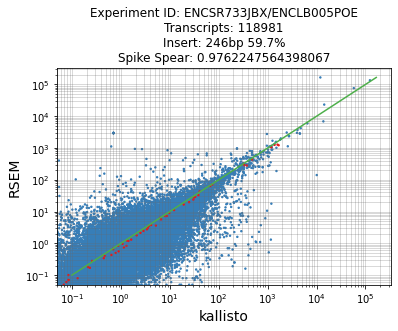

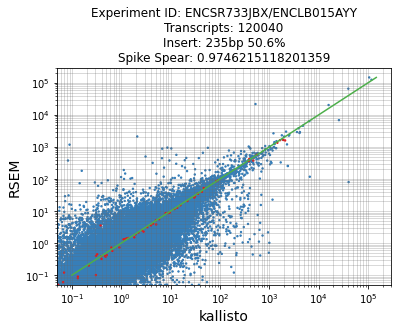

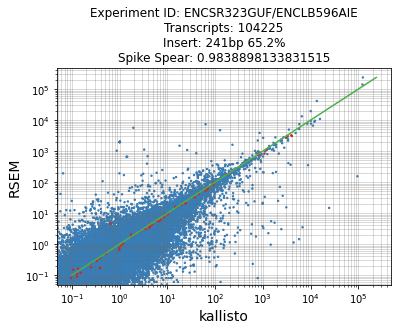

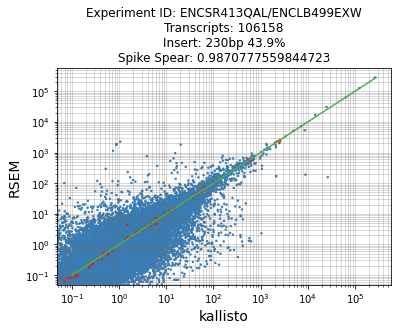

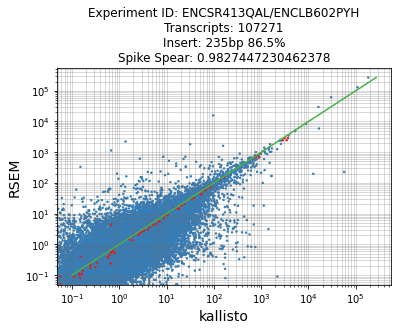

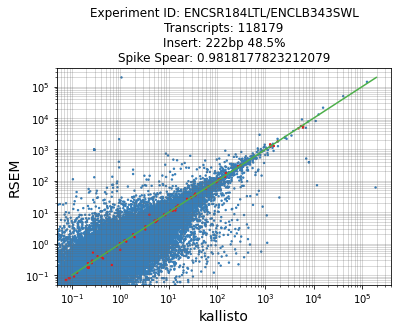

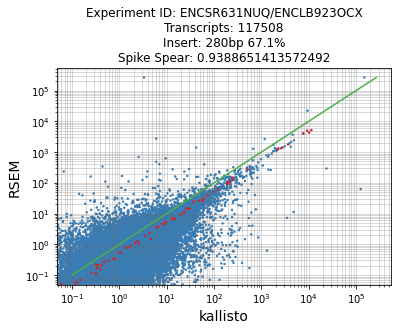

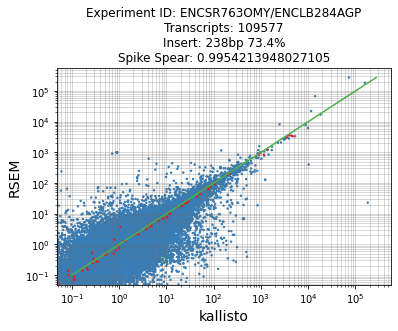

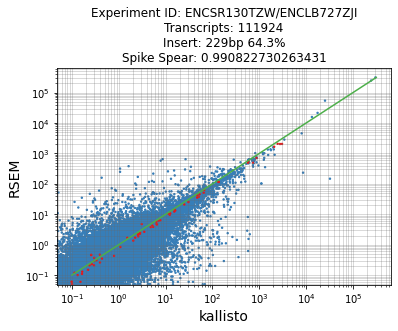

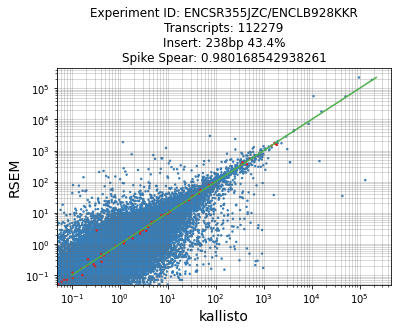

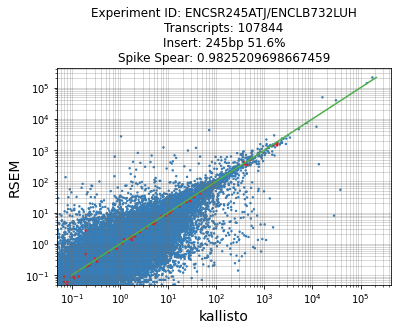

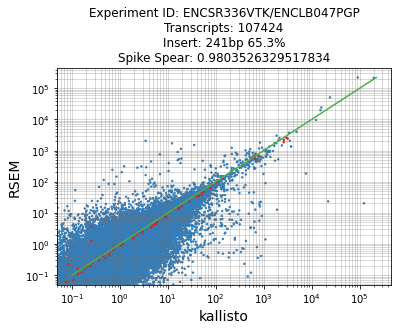

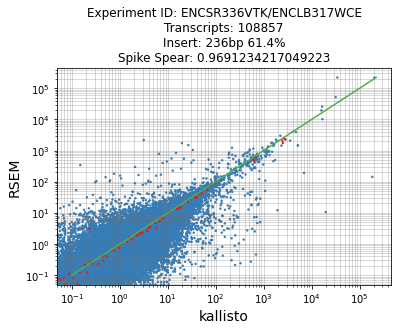

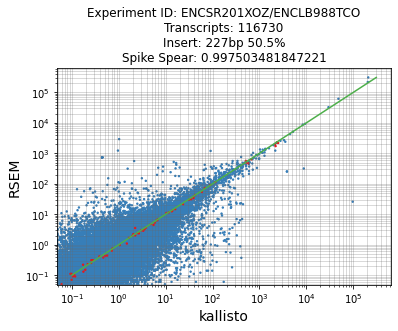

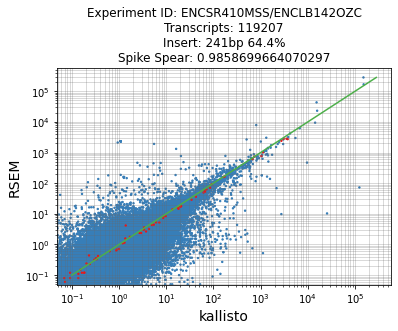

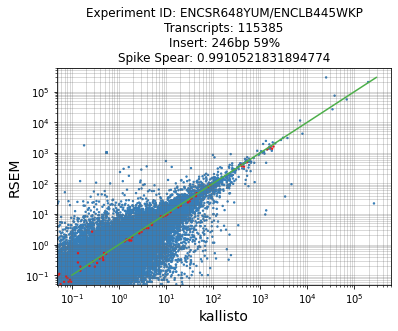

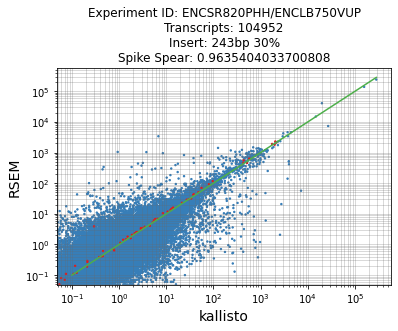

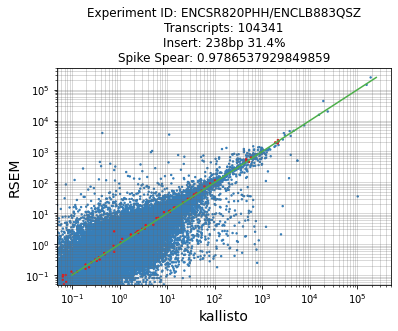

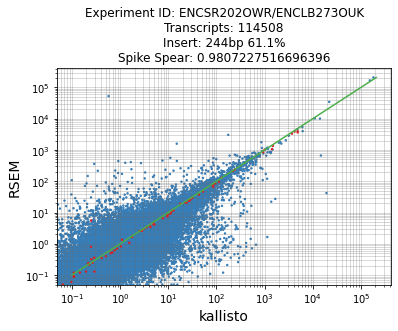

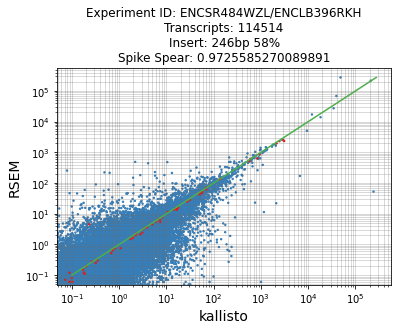

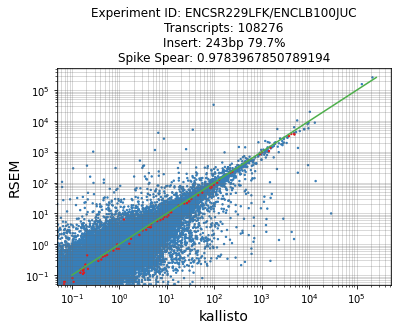

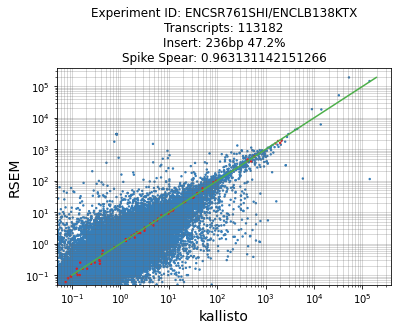

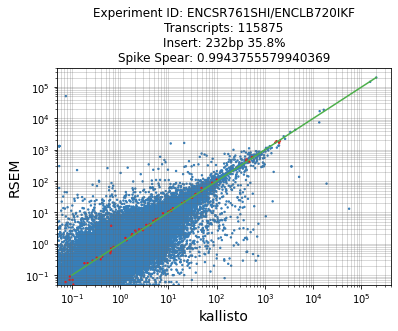

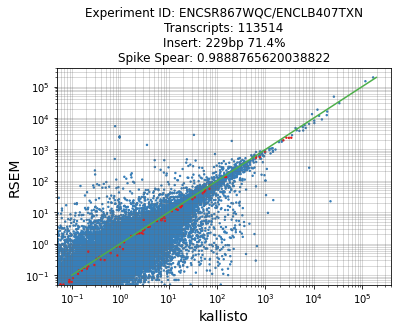

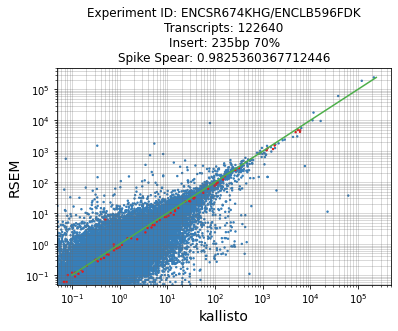

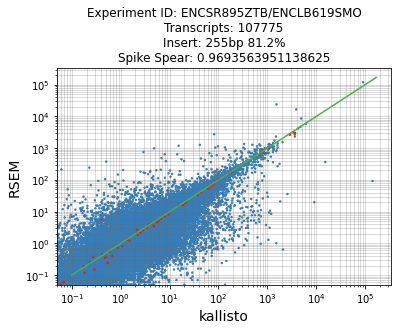

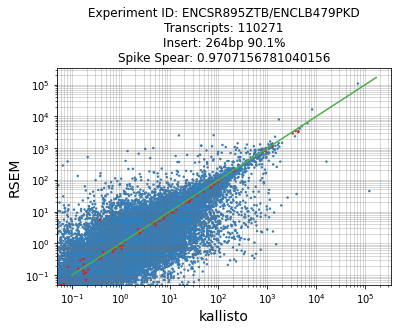

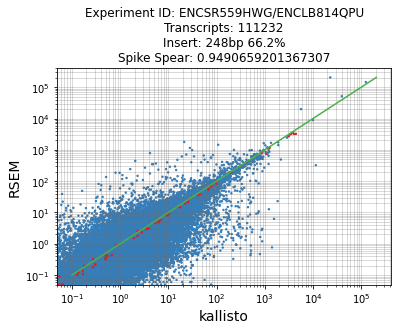

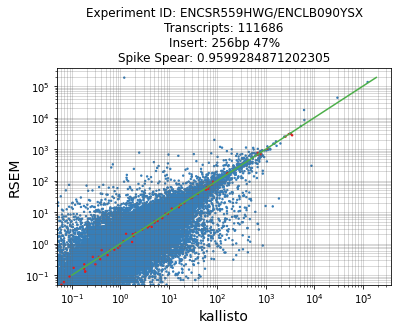

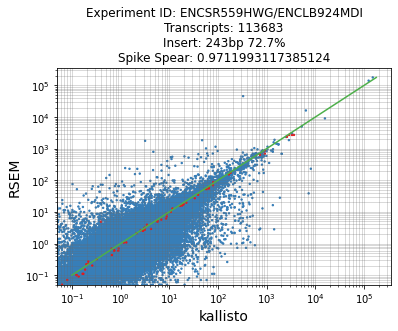

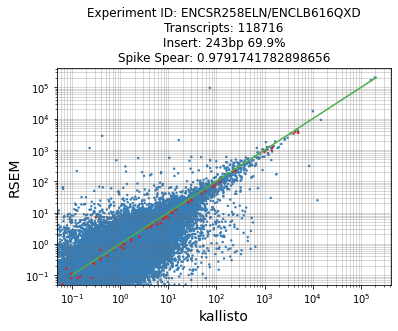

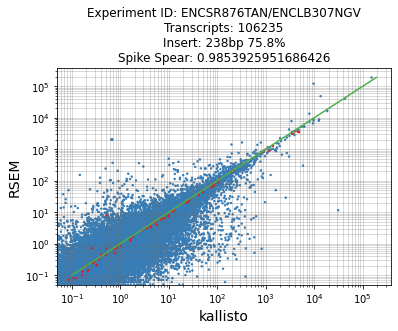

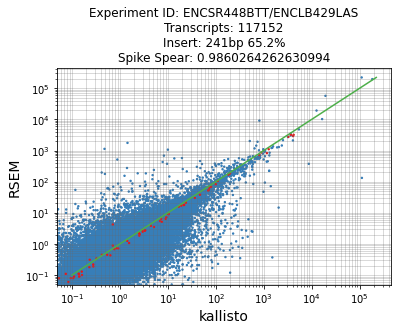

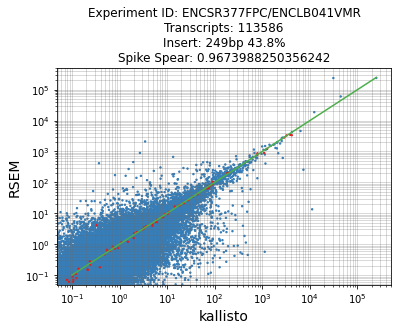

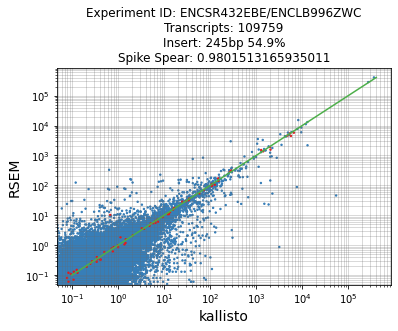

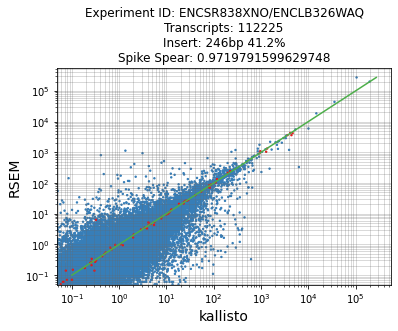

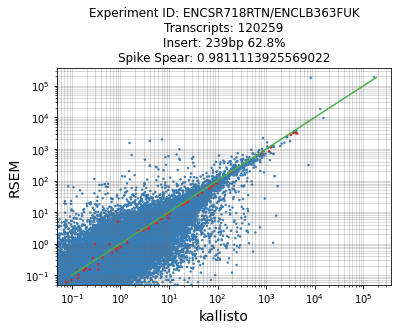

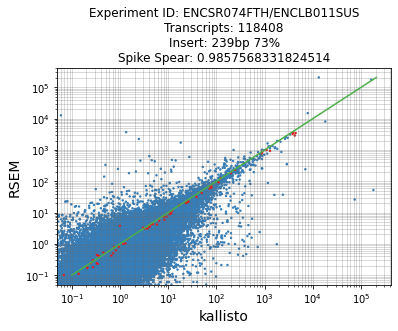

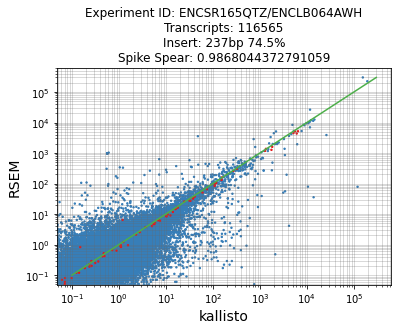

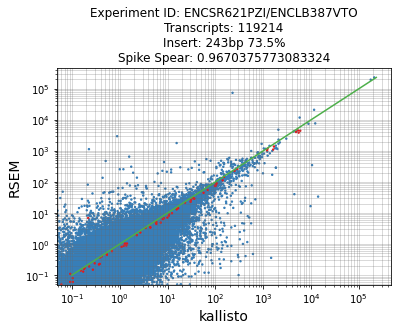

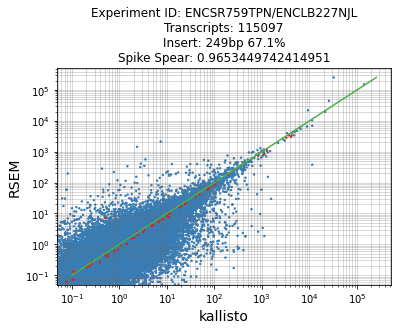

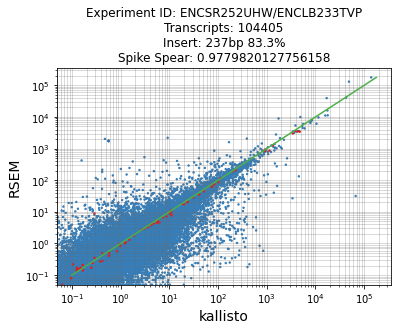

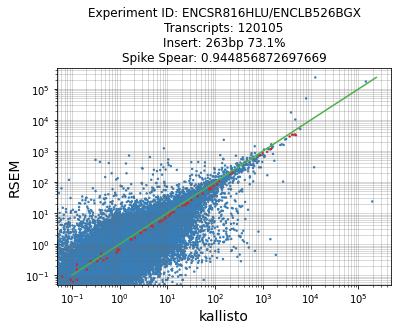

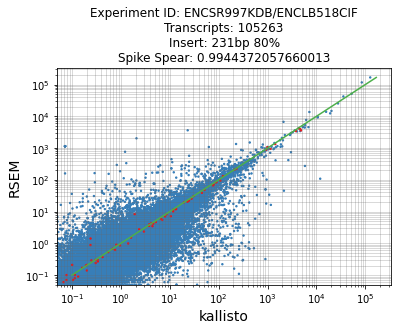

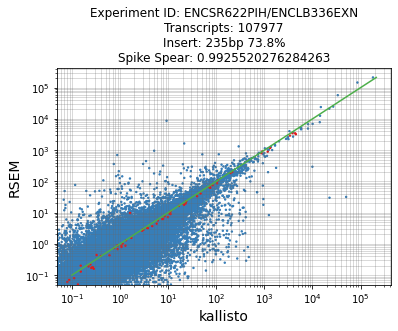

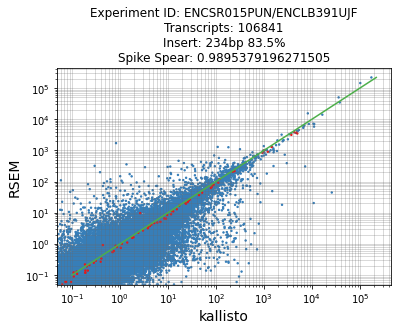

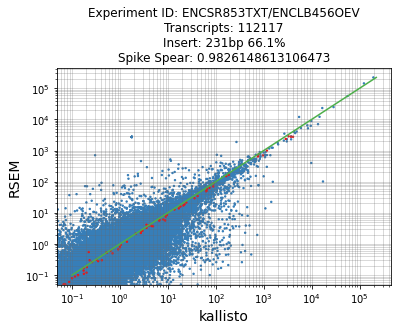

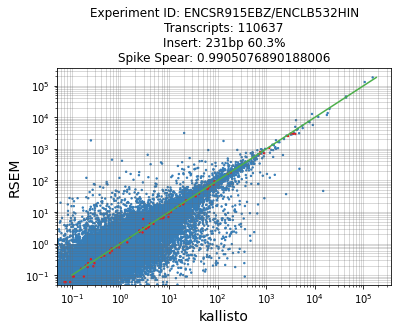

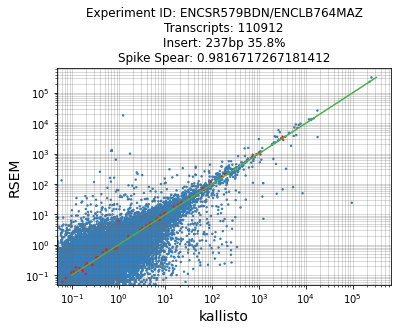

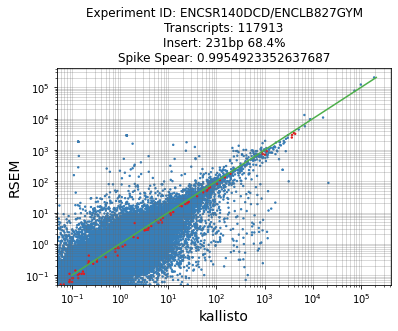

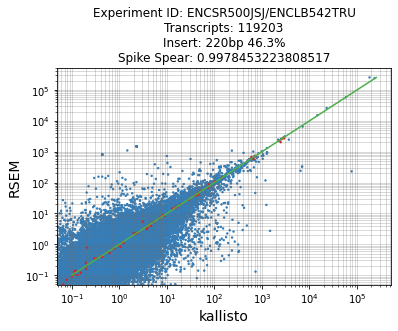

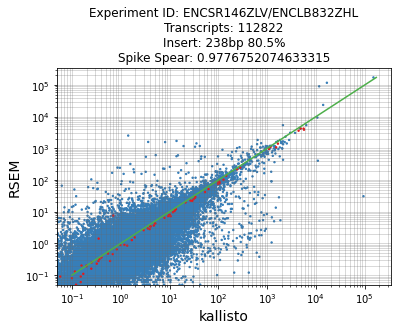

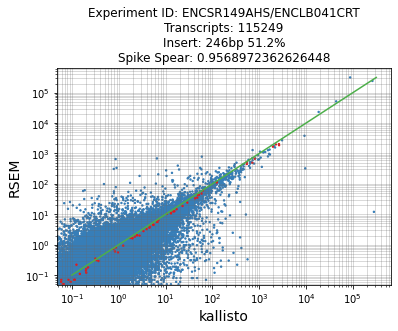

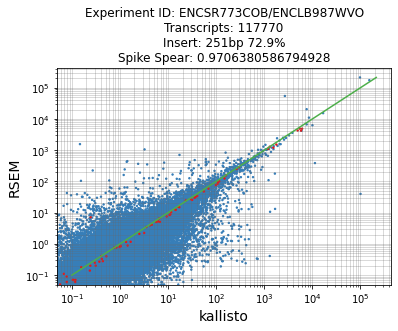

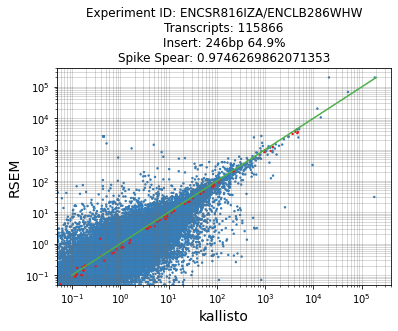

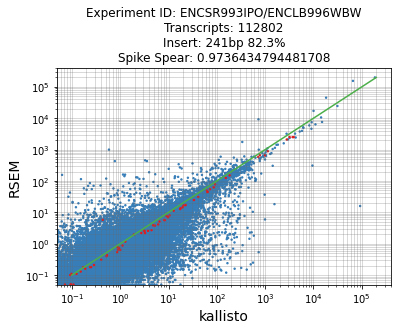

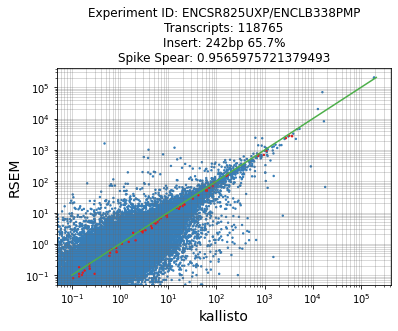

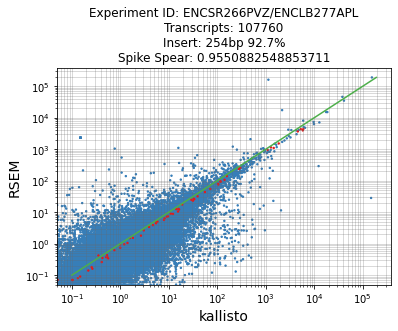

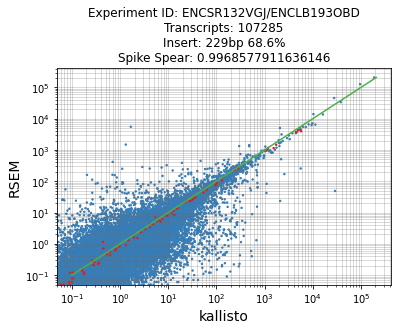

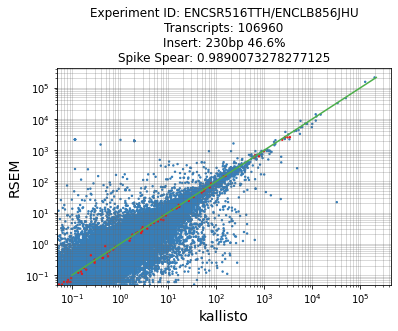

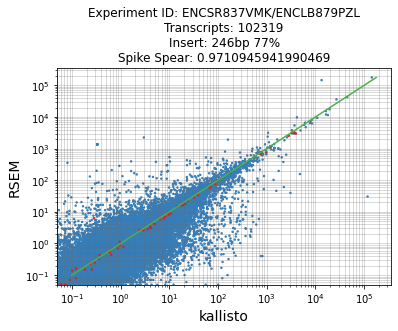

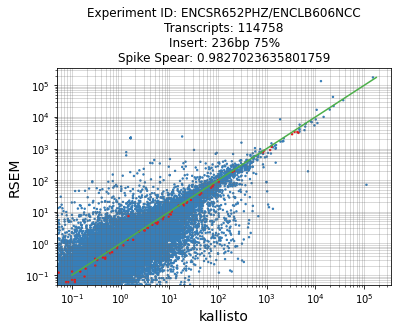

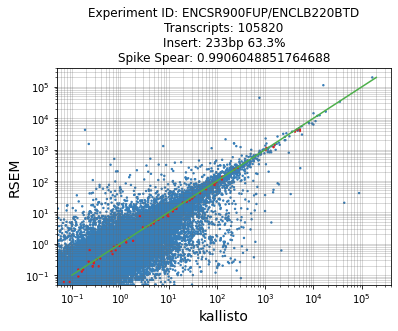

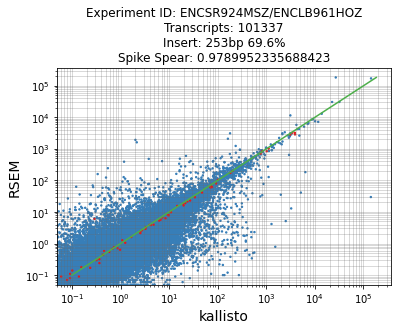

In [19]:
for i, e in enumerate(experiments):
    #print(i+1, len(experiments), e['accession'])
    quants = load_transcripts_by_library(e)
    for library_id in quants:
        rsem = quants[library_id].get('rsem')
        kallisto = quants[library_id].get('kallisto')
        library = server.get_json(library_id)
        
        if rsem is not None and kallisto is not None:
            kallisto_rsem_scatter(kallisto['tpm'], rsem['TPM'], e, library)


In [ ]:
#rsem = madqc.load_rsem_quantifications(
#    ['https://www.encodeproject.org/files/ENCFF567AFJ/@@download/ENCFF567AFJ.tsv'],
#    column='TPM',
#)
#kallisto = load_kallisto_transcript_abunduance('https://www.encodeproject.org/files/ENCFF364YTB/@@download/ENCFF364YTB.tsv')

In [ ]:
#kallisto.columns

In [ ]:
#kallisto_rsem_scatter(kallisto['tpm'], rsem['ENCFF567AFJ.tsv'], 'ENCSR924MSZ')